<a href="https://colab.research.google.com/github/kosinovna-1/mathpack2024/blob/main/homework6/Version_2!!!_MathPack_HW_06_Kosinov_group_bv_02_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Работа посвящена машинному обучению распознавания образов методом $PCA$. Будем обучать модель распознавать цифры. Вначале обучим модель, разберёмся в её работе, а затем оформим её работу в виде ООП.

Подключим тестовые данные из $mnist$.

In [1]:
from mnist import load_mnist
train, validation, test = load_mnist()

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


Проверим количество изображений обучающей выборки и формат хранения.

In [2]:
train[0].shape, train[1].shape

((55000, 28, 28, 1), (55000,))

Переведём изображения в удобный для нас формат.

* превратим каждое из изображений в строку пикселей;
* нормируем изображения так, чтобы среднее значение пикселей каждой картинки равнялось 0;
* посчитаем матрицу ковариации $C$ по формуле $(X-\overline{X})^T(X-\overline{X})$, где $X$ - исходный набор данных;
* найдём собственные значения и собственные векторы матрицы $C$;
* домножим $X$ на матрицу собственных векторов, чтобы привести $X$ к новой системе координат.

In [3]:
import numpy as np
X = train[0].reshape((55000,28**2))
X = X - X.mean(axis=0)
C = X.T.dot(X)
Values,Vectors = np.linalg.eigh(C)
Values = Values[::-1]
Vectors = Vectors[:,::-1]
Y = X.dot(Vectors)

Рассмотрим точечный график полученных данных и проекцию этого графика на оси первых двух координат.

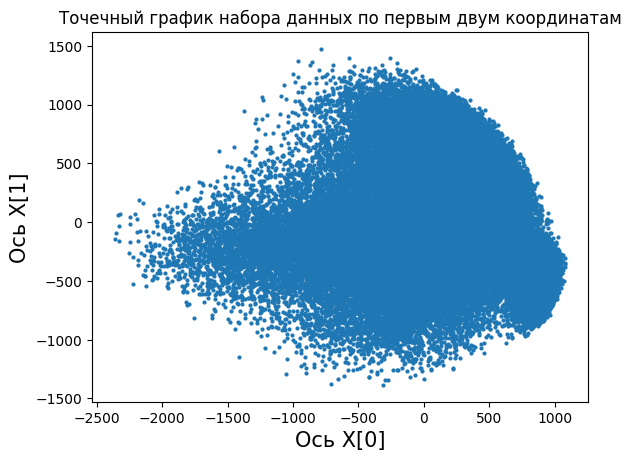

In [4]:
import matplotlib.pyplot as plt
plt.scatter(Y.T[0],Y.T[1],s=4)
plt.title("Точечный график набора данных по первым двум координатам")
plt.xlabel("Ось X[0]", fontsize=15)
plt.ylabel("Ось X[1]", fontsize=15)
plt.show()

Добавим цвет: покрасим точки, отвечающие разным циврам в разный цвет.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


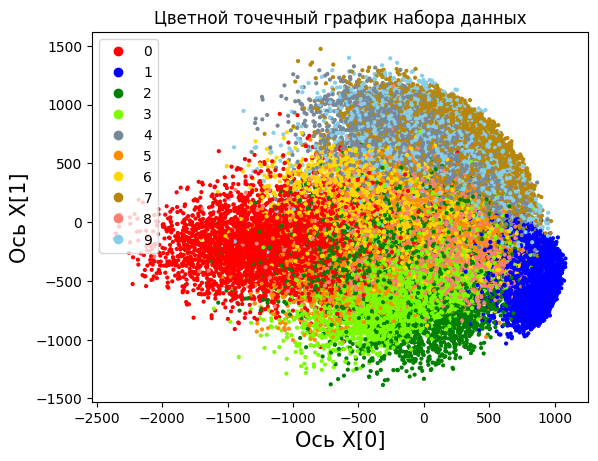

In [5]:
from matplotlib. colors import ListedColormap
color = ['red','blue','green','lawngreen','lightslategray',
         'darkorange','gold','darkgoldenrod','salmon','skyblue']
colors = np.vectorize(lambda x: color[x])(train[1])
sc = plt.scatter(Y.T[0],Y.T[1],s=4, c=train[1], cmap=ListedColormap(color))
plt.legend(handles=sc. legend_elements ()[ 0 ], labels=list(range(10)))
plt.title("Цветной точечный график набора данных")
plt.xlabel("Ось X[0]", fontsize=15)
plt.ylabel("Ось X[1]", fontsize=15)
plt.show()

Как мы видим, точки разбились на группы - одноцветные области. Это означает, что задача классификации решается успешно.

Теперь обучим модель отличать цифру на новом изображении. Для этого возьмём тестовую выборку из $mnist$. Для начала рассмотрим первые $n=100$ тестов.

In [6]:
ans = test[1]
def cut_test(n):
  tests = test[0].reshape(10000,28**2)[:n]
  tests = tests-tests.mean(axis=0)
  tests = tests.dot(Vectors)
  return tests
tests = cut_test(100)
tests.shape

(100, 784)

Теперь пишем функции для классификации нового изображения:

* $indexes$ - возвращает список расстояний до $k$ ближайших точек;
* $frequency$ - возвращает число, изображения с котоорым ближе всего к проверяемому изображению;
* $proc$ - функция, оценивающая точность модели в зависимости от количества рассматриваемых главных компонент $d$ и количества рассматриваемых ближайших точек $k$.

In [7]:
from scipy.spatial.distance import cdist
def indexes(test,d,k):
  #возвращает список рассотяний от данной картинки до всех в Trainе
  test = test[:d].reshape((1,d))
  distance = cdist(test, Y[:,:d]).reshape(55000)
  ind = np.argpartition(distance, k)[:k]
  return ind

def frequency(ind):
  vars = train[1][ind]
  vals, counts = np.unique(vars, return_counts=True)
  return vals[np.argmax(counts)]

def proc(d,k):
  results = np.vectorize(lambda x: int(ans[x] == frequency(indexes(tests[x],d,k))))(np.arange(len(tests)))
  return results.sum()*100/len(tests)

proc(200,101),len(tests)

(94.0, 100)

Графическим методом подберём оптимальные $d$ и $k$, когда угадываемость будет наиболее высокой. Начнём с экспоненциального роста.

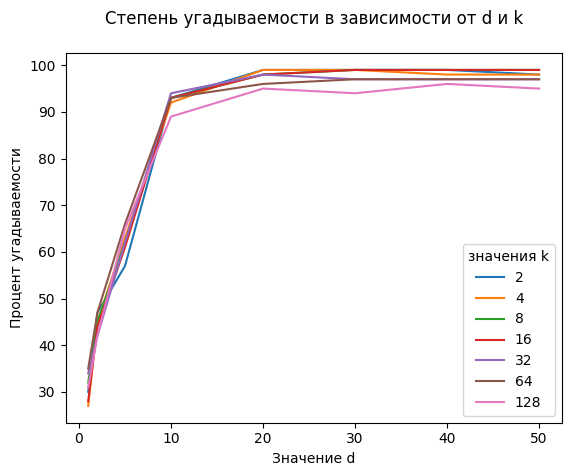

In [8]:
d = np.array([1,2,5,10,20,30,40,50])
ks = 2**np.arange(1,8)
for t in range(7):
  k = ks[t]
  res = np.vectorize(lambda x: proc(x,k))(d)
  plt.plot(d,res)
plt.legend(ks,title='значения k')
plt.title('Степень угадываемости в зависимости от d и k\n')
plt.xlabel('Значение d')
plt.ylabel('Процент угадываемости')
plt.show()

Видим, что довольно большая точность достигается уже при $10\le d\le 25$ и при всех малых $k$. Выберем графически одну пару.

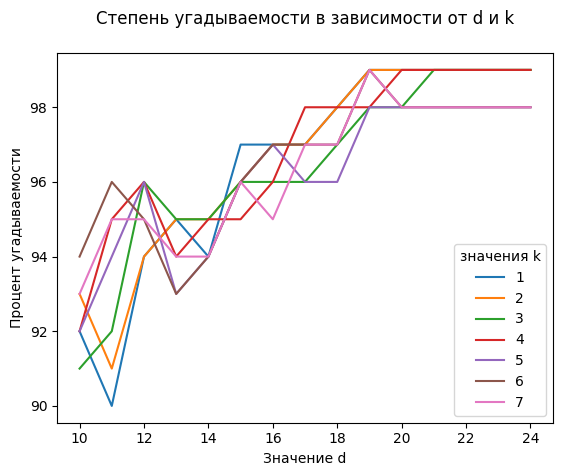

In [9]:
d = np.arange(10,25)
ks = np.arange(1,8)
for t in range(len(ks)):
  k = ks[t]
  res = np.vectorize(lambda x: proc(x,k))(d)
  plt.plot(d,res)
plt.legend(ks,title='значения k')
plt.title('Степень угадываемости в зависимости от d и k\n')
plt.xlabel('Значение d')
plt.ylabel('Процент угадываемости')
plt.show()

Добавим плавности, чтобы лучше отличать линии друг от друга. Заодно, попробуем увеличить тестовую выборку до 200

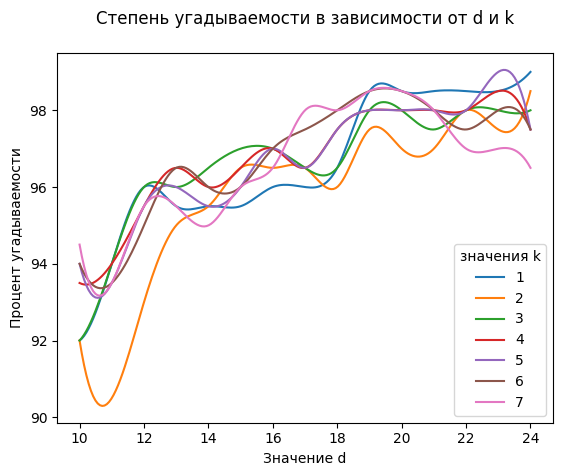

In [10]:
from scipy.interpolate import make_interp_spline, BSpline

tests = cut_test(200)

for t in range(len(ks)):
  k = ks[t]
  res = np.vectorize(lambda x: proc(x,k))(d)
  xnew = np.linspace (d. min (), d. max (), 200 )
  spl = make_interp_spline (d, res, k= 3 )
  y_smooth = spl (xnew)
  plt.plot (xnew, y_smooth)
plt.legend(ks,title='значения k')
plt.title('Степень угадываемости в зависимости от d и k\n')
plt.xlabel('Значение d')
plt.ylabel('Процент угадываемости')
plt.show()

Остановимся на числе компонент $d=20$ и посмотрим на степень угадываемости в зависимости от $k$.

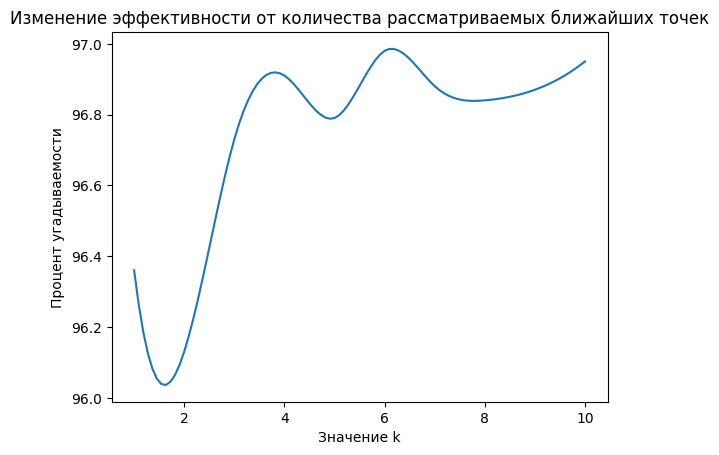

In [11]:
tests = cut_test(10000)

d = 20
k = np.arange(1,11)
res = np.vectorize(lambda x: proc(d,x))(k)
xnew = np.linspace (k. min (), k. max (), 100 )
spl = make_interp_spline (k, res, k= 3 )
y_smooth = spl (xnew)
plt.plot (xnew, y_smooth)
plt.title('Изменение эффективности от количества рассматриваемых ближайших точек')
plt.xlabel('Значение k')
plt.ylabel('Процент угадываемости')
plt.show()

Мы видим, что процент угадываемости колеблется от $96\%$ до $97\%$. Поэтому, если порядок точности нас устраивает, достаточно взять $k=6$ ближайших точек.

Для проверки работы всего алгоритма, выведем несколько цифр и значения, которым их определил алгоритм.

In [12]:
tests = np.array(test[0])
tests.shape

(10000, 28, 28, 1)

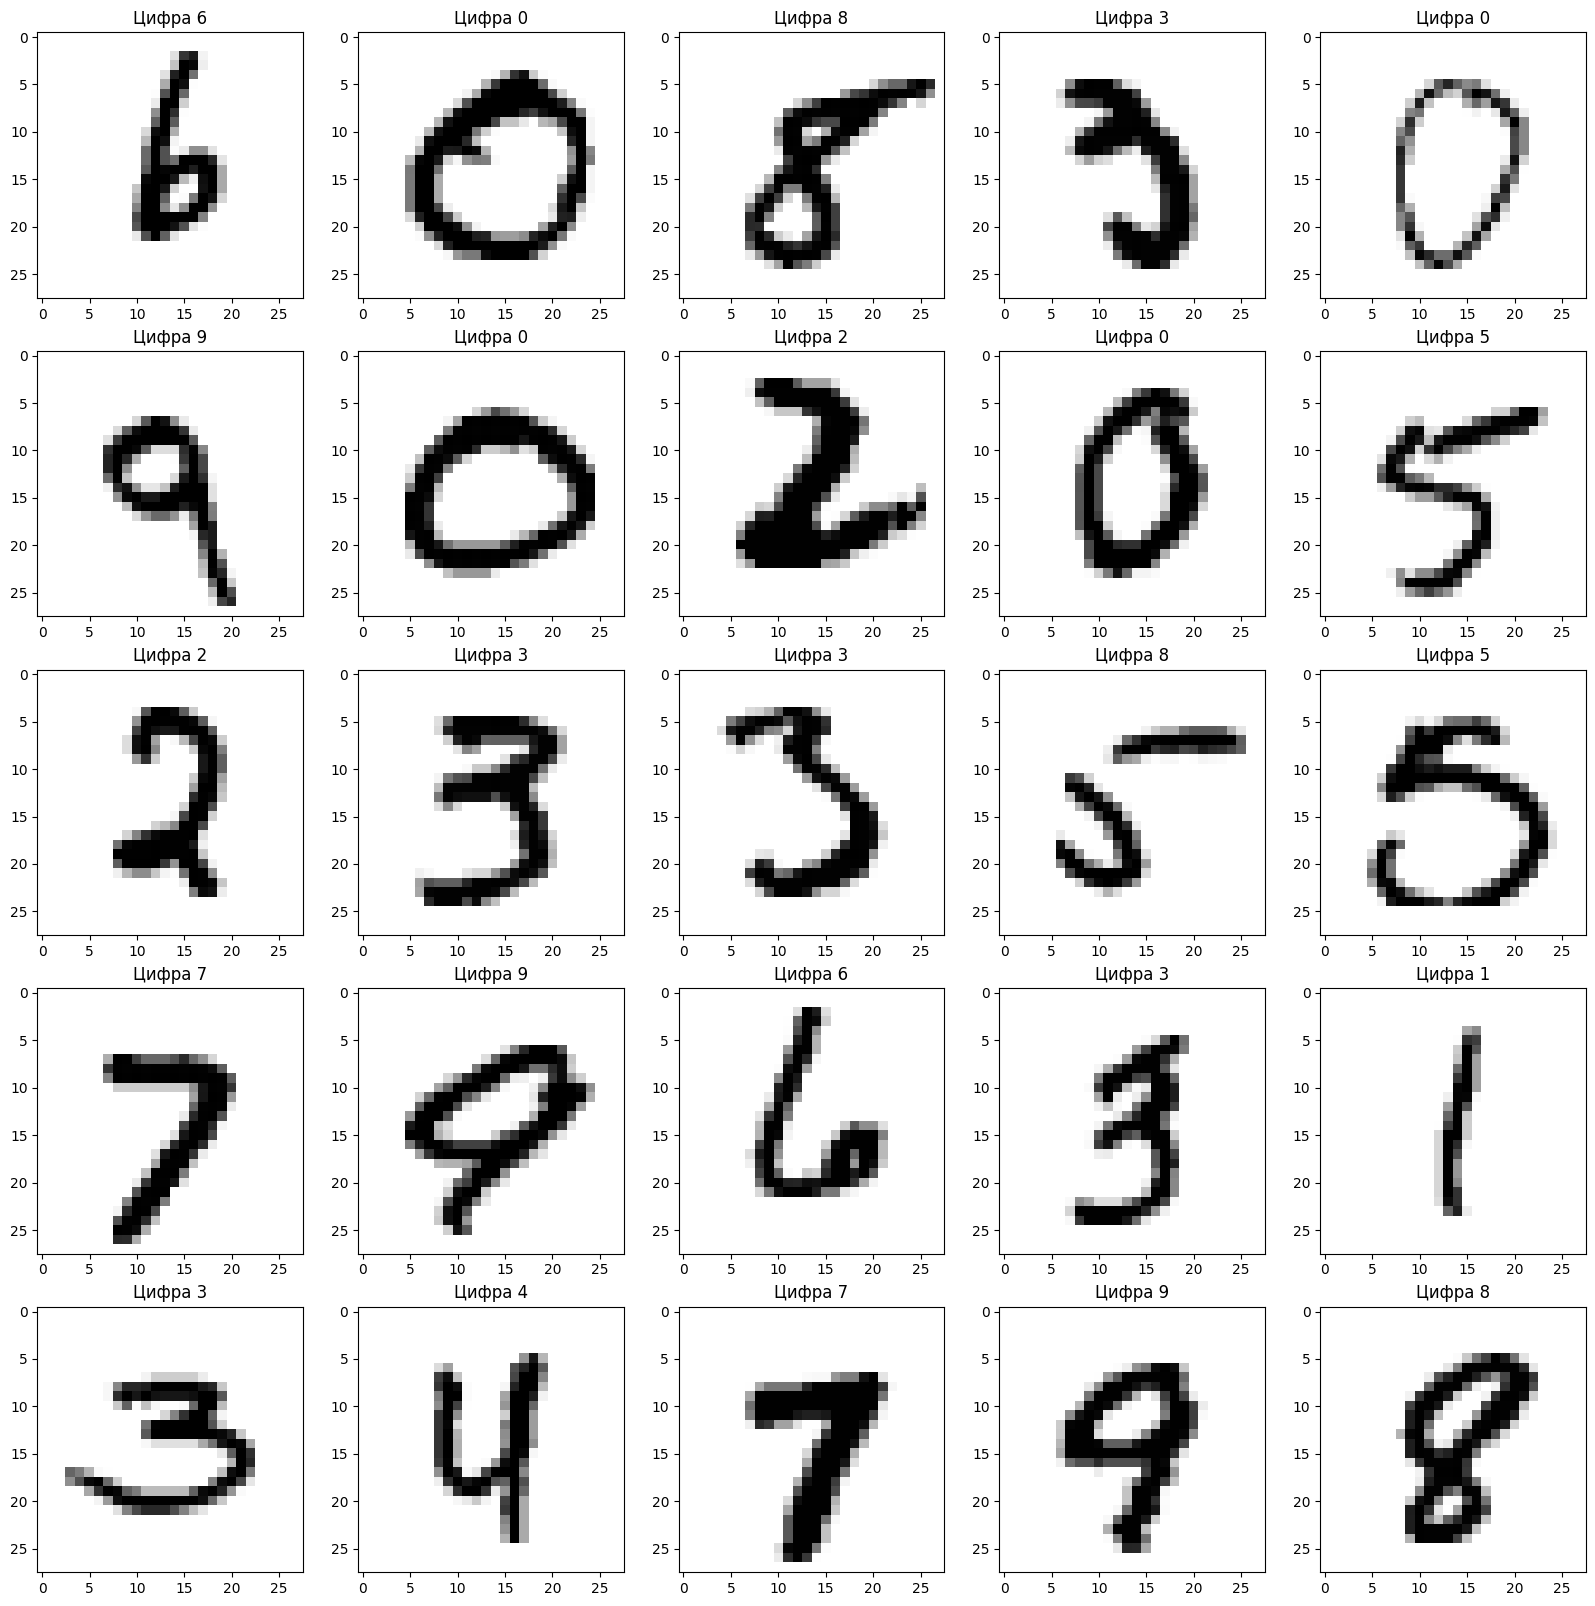

In [78]:
from random import randint

def answer(picture, d=20, k=6):
  picture = picture.reshape(28**2)
  picture = picture-picture.mean()
  picture = picture.dot(Vectors)
  ans = frequency(indexes(picture,d,k))
  return ans

fig, axis = plt.subplots(5, 5, figsize = (20, 20))
for i in range(5):
    for j in range(5):
      picture = tests[randint(0,9999)]
      ans = answer(picture)
      axis[i, j].set_title('Цифра ' + str(ans))
      axis[i, j].imshow(picture, cmap = 'binary')


24 из 25 угадываний!

Теперь оформим наш код в виде классов.

In [54]:
class my_PCA():
    import numpy as np

    def __init__(self, n_components = 20):
        self.components = d

    def fit(self, X):
        X = X[0].reshape((55000,28**2))
        X = X - X.mean(axis=0)
        C = X.T.dot(X)
        Values,Vectors = np.linalg.eigh(C)
        Values = Values[::-1]
        Vectors = Vectors[:,::-1]
        return X, Vectors, Values

    def transform(self, X, Vectors):
        Y = X.dot(Vectors)
        return Y

    def fit_transform(self, X):
        answers = X[1]
        X, Vectors, Values = self.fit(X)
        Y = self.transform(X, Vectors)[:,:self.components]
        return Y,Vectors,answers


In [76]:
class my_kNN():
    from scipy.spatial.distance import cdist

    def __init__(self, myPCA, n_neighbors=5):
        self.neighbors = 5
        self.myPCA = myPCA

    def fit(self, X):
        Y = self.myPCA[0]
        X = X[:len(Y[0])]
        X = X.reshape(1,len(X))
        #print(X.shape,Y.shape,len(Y[0]))
        distance = cdist(X, Y).reshape(55000)
        ind = np.argpartition(distance, self.neighbors)[:self.neighbors]
        vars = self.myPCA[2][ind]
        vals, counts = np.unique(vars, return_counts=True)
        return vals[np.argmax(counts)]

    def predict(self, X):
        picture = X.reshape(28**2)
        picture = picture-picture.mean()
        picture = picture[:len(self.myPCA[0])]
        picture = picture.dot(self.myPCA[1])
        ans = self.fit(picture)
        return ans

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
55000


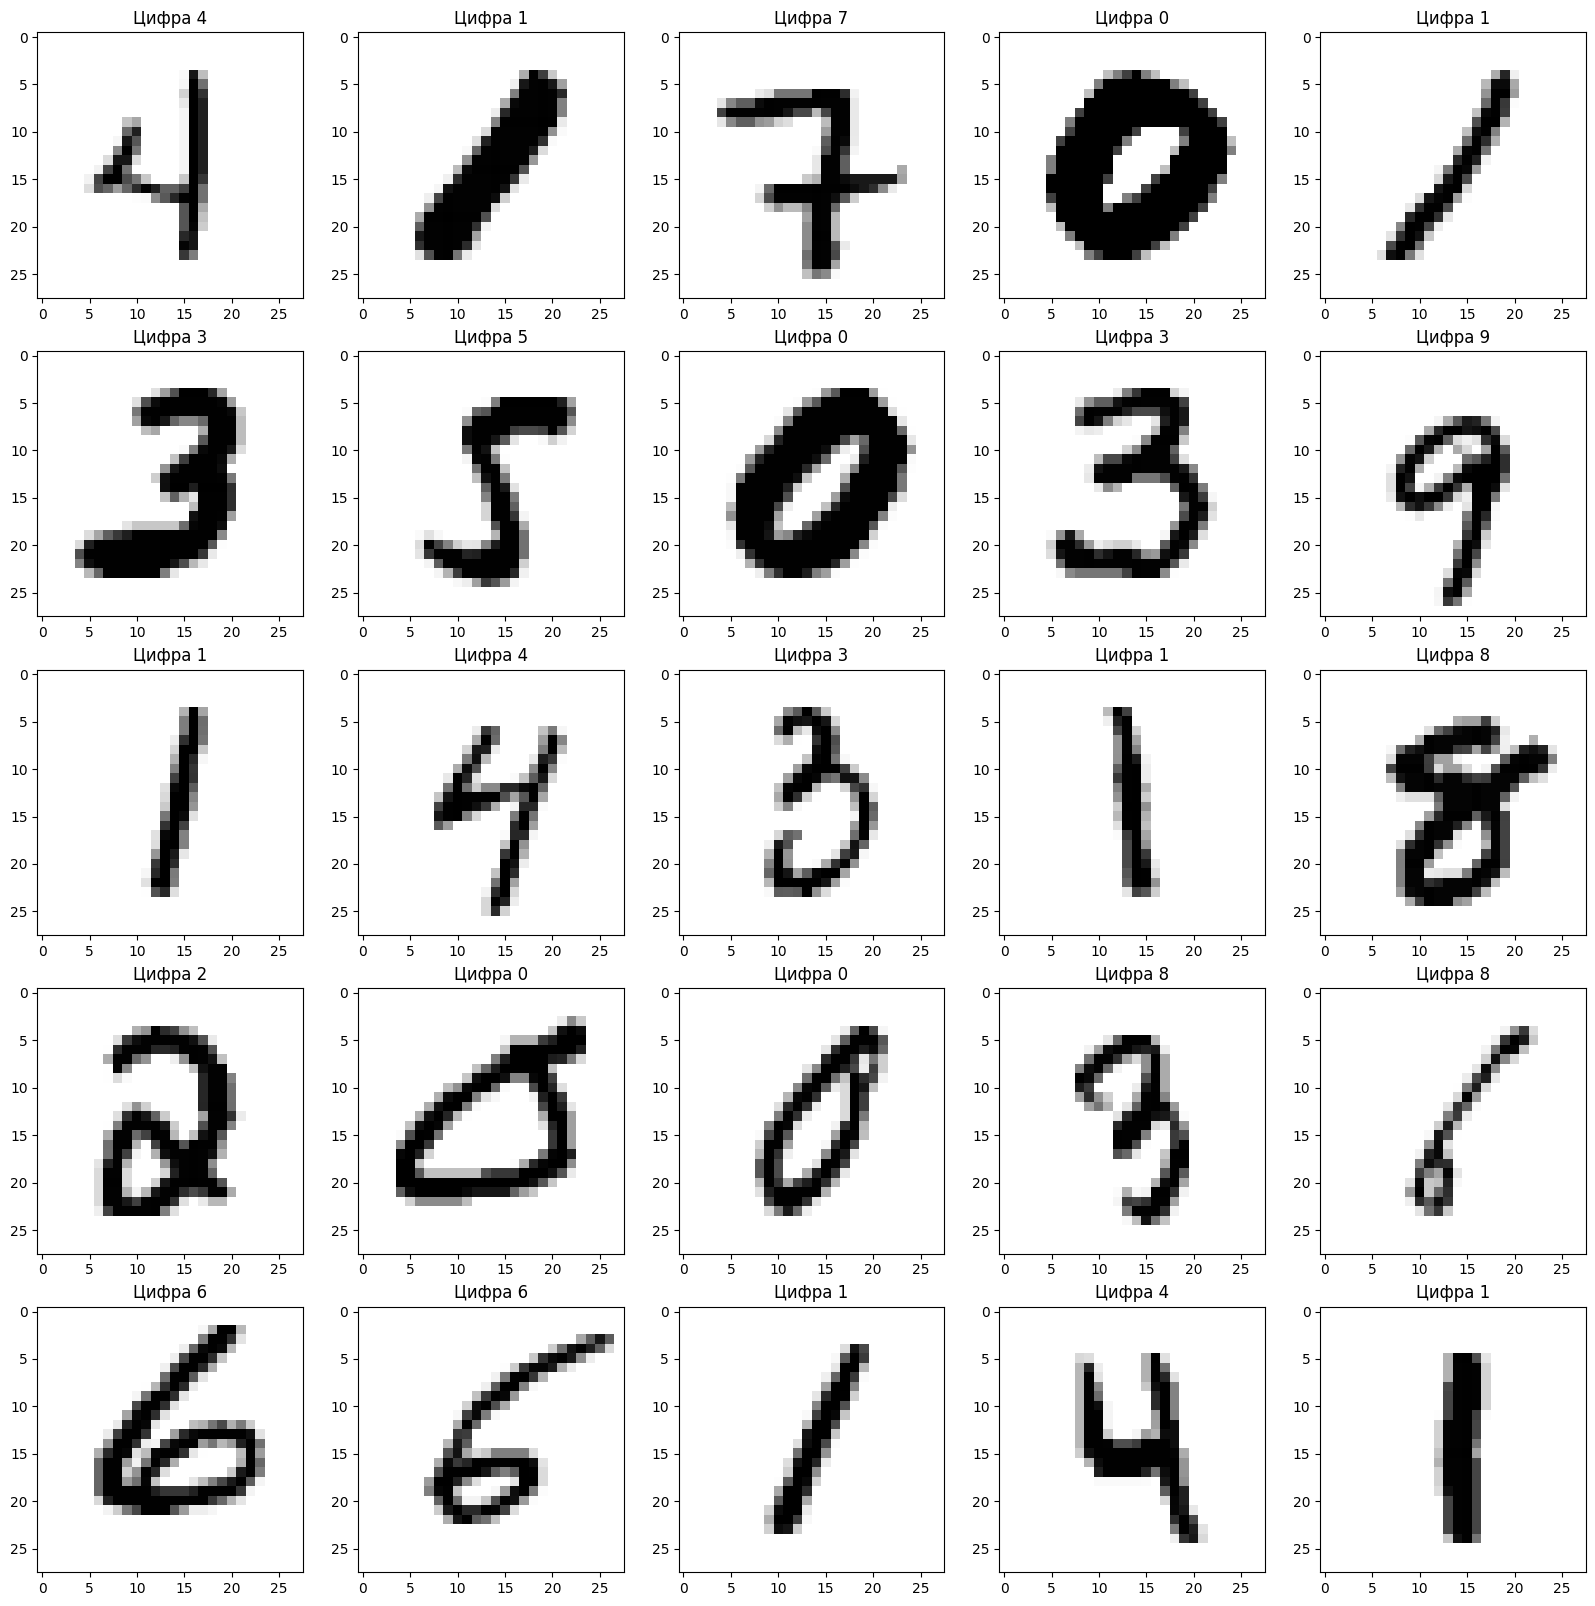

In [77]:
from mnist import load_mnist
train, validation, test = load_mnist()

fig, axis = plt.subplots(5, 5, figsize = (20, 20))

myPCA = my_PCA(20).fit_transform(train)
print(len(myPCA[0]))
kNN = my_kNN(myPCA,6)

for i in range(5):
    for j in range(5):
      picture = tests[randint(0,9999)]
      ans = kNN.predict(picture)
      axis[i, j].set_title('Цифра ' + str(ans))
      axis[i, j].imshow(picture, cmap = 'binary')